# An overview to LUTO model

In [ ]:
# HIDE CODE

'''
Here are the code to run LUTO first, so that we can have the variables and objects required for illustration in the notebook.
'''

# Reload all modules before excuting each cell, so that we can modify the imported custom functions on-the-fly without rerun the whole model.
%load_ext autoreload
%autoreload 2


# Imports
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# cd to the root folder of the project
os.chdir('N:/LUF-Modelling/LUTO2_JZ/luto-2.0')
from luto.tools.Manual_jupyter_books.helpers import map_to_4band, mrj_to_xr, arr_to_xr, map_to_plot
from luto.economics.agricultural.quantity import get_quantity_matrices
from luto.tools.Manual_jupyter_books.helpers.parameters import legend_params


# # Run LUTO
# import luto.simulation as sim
# data = sim.load_data()
# sim.run(data=data, base=2010, target=2015)

## National Land-use Map of Australia for 2010

In [502]:
# HIDE CODE

# Define year, lu_code
year_begin = 2010
year_target = 2050
lu_code = 25 # Winter cereals
lu_desc = data.AGRICULTURAL_LANDUSES[lu_code]


# Get the lumap
lumap = mrj_to_xr(data, data.ag_dvars[year_begin])
lu_arr_dry = lumap.sel(lm='dry',lu='Winter cereals')
lu_arr_irr = lumap.sel(lm='irr',lu='Winter cereals')

lu_mask = arr_to_xr(data, np.ones_like(lumap)) == 1
lu_area = arr_to_xr(data, data.REAL_AREA)


# Get colors/names for pixcels with values of [-1, 0, 1]
colors = [
    (231, 232, 234, 255), # Light grey
    (169, 209, 229, 255), # Light blue
    (236, 147, 116, 255)  # Light red
]

cell_names = [
    'Non-Agricultural', 
    'Other Agricultural', 
    'Winter cereals'
]

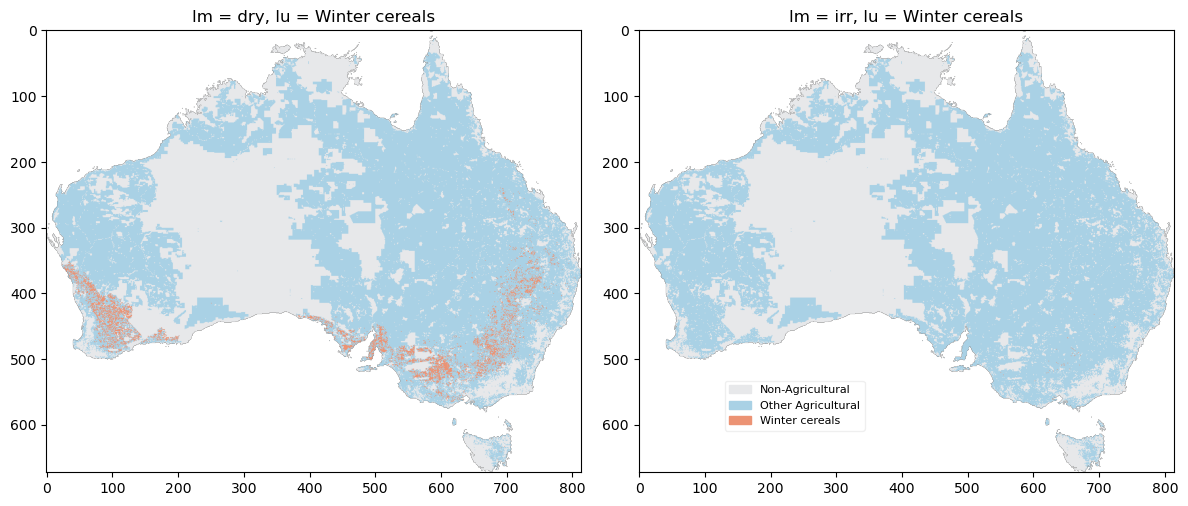

In [39]:
# HIDE CODE

# Create a figure and a set of subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first map (dry) on the first axis
map_to_plot(lu_arr_dry, colors, cell_names, legend_params, ax=axs[0])
axs[0].set_title(f'lm = dry, lu = {lu_desc}')

# Plot the second map (irr) on the second axis
map_to_plot(lu_arr_irr, colors, cell_names, legend_params, ax=axs[1])
axs[1].set_title(f'lm = irr, lu = {lu_desc}')

# Optionally, adjust the layout
plt.tight_layout()

# Show the combined plots
plt.show()

## Demand

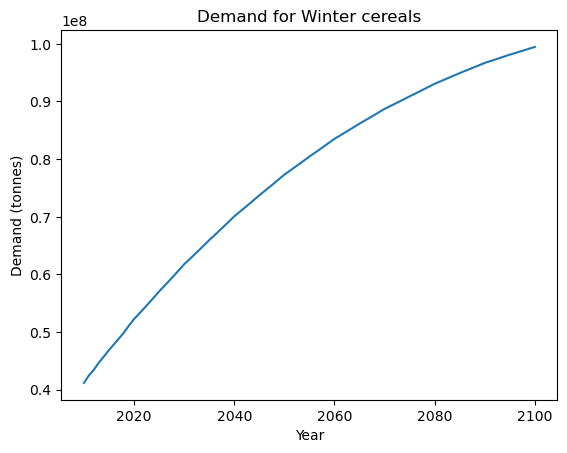

In [481]:
# Get the demand data
demand_df = data.DEMAND_DATA.unstack().reset_index()
demand_df.columns = ['Type', 'Year', 'Commodity', 'Value']


# Get the demand for the selected land use
demand_lu = demand_df.query('Type == "PRODUCTION" and Commodity == @lu_desc.lower()')


# Plot the demand
plt.plot(demand_lu['Year'], demand_lu['Value'])
plt.ylabel('Demand (tonnes)')
plt.xlabel('Year')
plt.title(f'Demand for {lu_desc}')
plt.show()

In [490]:
# Get the demand for the target year
demand_vol = demand_lu.query('Year == @year_target')['Value'].values[0] / 1e6  # Million tonnes

print(f'The demand for {lu_desc} in {year_target} is {demand_vol:.2f} million tonnes.')

The demand for Winter cereals in 2050 is 77.31 million tonnes.


## Productivity

In [482]:
'''
The acronyms for the columns in the `AGEC_CROPS` dataset are as follows:

AC - Area cost ($/ha)
FDC - Fixed depreciation cost ($/ha)
FLC - Fixed labour cost ($/ha)
FOC - Fixed operating cost ($/ha)
P1 - Price of output 1 ($/t); For crops, this is the only variable for price
QC - Quantity cost ($/t)
WR - Water requirement (t/ha)
WP - Water price ($/t)


There are additional columns for the `AGEC_LVSTK` data:

F1 - Fraction of herd to produce <Meat for `BEEF` and `SHEEP`> and <milk for `DAIRY`>
F2 - Fraction of herd to produce `WOOL` for `SHEEP`
F3 - Fraction of herd as `Live export` for `BEEF` and `SHEEP`

Q1 - Quantity of output 1 (tonnes/head); 
Q2 - Quantity of output 2 (tonnes/head);
Q3 - Quantity of output 3 (animal weight tonnes/head);

P1 - Price of output 1 ($/t); ($/tonne of meat for `BEEF` and `SHEEP`, $/tonne of milk for `DAIRY`)
P2 - Price of output 2 ($/t); ($/tonne of wool for `SHEEP`)
P3 - Price of output 3 ($/t); ($/tonne of live export for `BEEF` and `SHEEP`)

WR_DRN - Water requirement (t/head);
WR_IRR - Water requirement (t/ha); This only applies to `irrigated` livestock
'''

'\nThe acronyms for the columns in the `AGEC_CROPS` dataset are as follows:\n\nAC - Area cost ($/ha)\nFDC - Fixed depreciation cost ($/ha)\nFLC - Fixed labour cost ($/ha)\nFOC - Fixed operating cost ($/ha)\nP1 - Price of output 1 ($/t); For crops, this is the only variable for price\nQC - Quantity cost ($/t)\nWR - Water requirement (t/ha)\nWP - Water price ($/t)\n\n\nThere are additional columns for the `AGEC_LVSTK` data:\n\nF1 - Fraction of herd to produce <Meat for `BEEF` and `SHEEP`> and <milk for `DAIRY`>\nF2 - Fraction of herd to produce `WOOL` for `SHEEP`\nF3 - Fraction of herd as `Live export` for `BEEF` and `SHEEP`\n\nQ1 - Quantity of output 1 (tonnes/head); \nQ2 - Quantity of output 2 (tonnes/head);\nQ3 - Quantity of output 3 (animal weight tonnes/head);\n\nP1 - Price of output 1 ($/t); ($/tonne of meat for `BEEF` and `SHEEP`, $/tonne of milk for `DAIRY`)\nP2 - Price of output 2 ($/t); ($/tonne of wool for `SHEEP`)\nP3 - Price of output 3 ($/t); ($/tonne of live export for `BE

In [ ]:
# Convert the `AGEC_CROPS` data to 2D xarray
agec_crops_xr = []
for col in data.AGEC_CROPS.columns:
    series = data.AGEC_CROPS[col]
    series_xr = arr_to_xr(data, series).expand_dims({
        'Type': [col[0]], 
        'lm': [col[1]], 
        'lu': [col[2]]
    })
    agec_crops_xr.append(series_xr)

# Combine the xarray objects
agec_crops_xr = xr.combine_by_coords(agec_crops_xr)

# Get the data for the given land-use
agec_crops_xr_lu = agec_crops_xr.sel(lu=lu_desc)

In [ ]:
# Helper function to plot the quantity matrices
def plot_dry_irr(dry_irr, irr_arr):

    # Create a figure and a set of subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))

    # Plot the maps side by side
    dry_irr.plot(vmin=dry_irr.min(), vmax=dry_irr.max(), ax=axs[0], cmap='viridis')
    irr_arr.plot(vmin=irr_arr.min(), vmax=irr_arr.max(), ax=axs[1], cmap='viridis')

    # Optionally, adjust the layout
    plt.tight_layout()

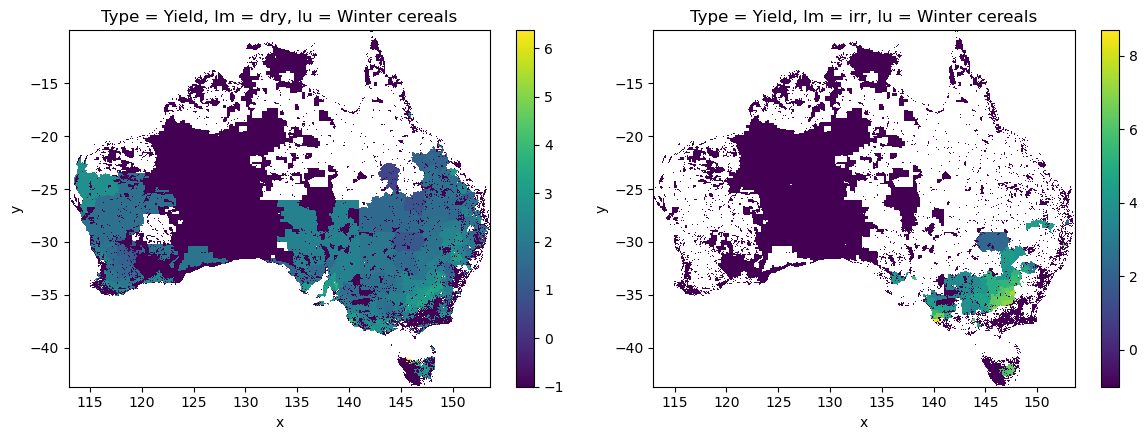

In [390]:
# Get the yield for the given land-use
p_dry = agec_crops_xr_lu.sel(Type='Yield', lm='dry').drop_vars('spatial_ref')
p_irr = agec_crops_xr_lu.sel(Type='Yield', lm='irr').drop_vars('spatial_ref')

plot_dry_irr(p_dry, p_irr)

## Climate change impacts

In [469]:
# Convert the `AGEC_CROPS` data to 2D xarray
cci_crops_xr = []
for col in data.CLIMATE_CHANGE_IMPACT.columns:
    series = data.CLIMATE_CHANGE_IMPACT[col]
    series_xr = arr_to_xr(data, series).expand_dims({
        'lm': [col[0]], 
        'lu': [col[1]], 
        'year': [col[2]]
    })
    cci_crops_xr.append(series_xr)

# Combine the xarray objects
cci_crops_xr = xr.combine_by_coords(cci_crops_xr)


# Append ones as the climate change impact in year 2010
cci_ones_dry = cci_crops_xr.sel(lm=['dry'], year=[2020])
cci_ones_dry.data = np.ones_like(cci_ones_dry.data)
cci_ones_dry.coords['year'] = [2010]
cci_ones_irr = cci_crops_xr.sel(lm=['irr'], year=[2020])
cci_ones_irr.data = np.ones_like(cci_ones_irr.data)
cci_ones_irr.coords['year'] = [2010]
cci_crops_xr = xr.combine_by_coords([cci_crops_xr, cci_ones_dry, cci_ones_irr])


# Get the data for the given land-use
cci_crops_xr_lu = cci_crops_xr.sel(lu=lu_desc)
# Linearly interpolate the data to 2010-2100
cci_crops_xr_lu = cci_crops_xr_lu.interp(year=range(2010, 2101), method='linear', kwargs={"fill_value": "extrapolate"})

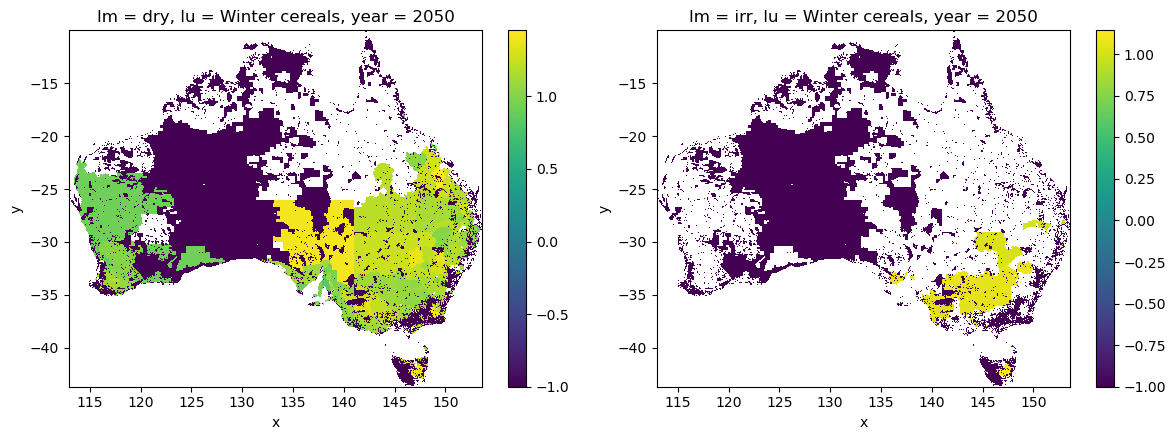

In [473]:
# Get the data for the given year
cci_dry = cci_crops_xr_lu.sel(lm='dry', year=year_target).drop_vars('spatial_ref')
cci_irr = cci_crops_xr_lu.sel(lm='irr', year=year_target).drop_vars('spatial_ref')

plot_dry_irr(cci_dry, cci_irr)

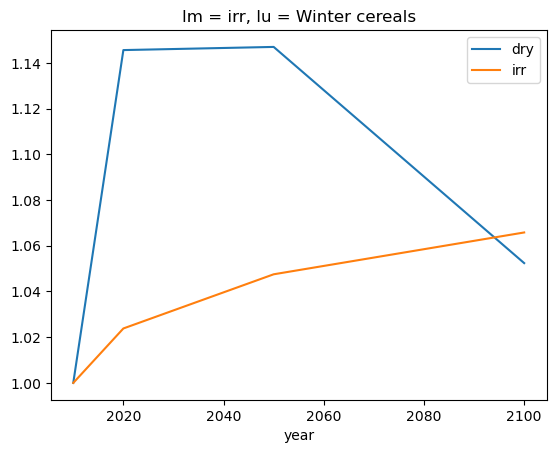

In [471]:
cci_crops_xr_lu_mean = (cci_crops_xr_lu * lu_mask.where(lu_mask == 1)).mean(dim=['x','y']) 
cci_dry_mean = cci_crops_xr_lu_mean.sel(lm='dry').drop_vars('spatial_ref')
cci_irr_mean = cci_crops_xr_lu_mean.sel(lm='irr').drop_vars('spatial_ref')


cci_dry_mean.plot()
cci_irr_mean.plot()
plt.legend(['dry', 'irr'])

## Commodity production 

In [509]:
# HIDE CODE

mrp_xr =[]
for year in [year_begin, year_target]:
    yr_idx = year - year_begin
    # Get the quantity matrices
    q_mrp = get_quantity_matrices(data, yr_idx).astype(np.float32)        # t/cell
    q_mrp_xr = mrj_to_xr(data, q_mrp).expand_dims({'year': [year]})
    mrp_xr.append(q_mrp_xr)
    
# Combine the xarray objects
mrp_xr = xr.combine_by_coords(mrp_xr)

In [515]:
# Calculate the total quantity for each water supply
q_dry_begin = mrp_xr.sel(lm='dry', year=year_begin, lu=lu_desc.upper()).drop_vars('spatial_ref')
q_irr_begin = mrp_xr.sel(lm='irr', year=year_begin, lu=lu_desc.upper()).drop_vars('spatial_ref')

q_dry_total = lu_arr_dry.values * q_dry_begin.values       
q_dry_total = np.nansum(q_dry_total) / 1e6          # million t               

q_irr_total = lu_arr_irr.values * q_irr_begin.values     
q_irr_total = np.nansum(q_irr_total) / 1e6          # million t 

# Get the total quantity for the given land-use
q_total = q_dry_total + q_irr_total                 # million t       

print(f'Total quantity for {lu_desc} in {year_begin}: {q_total:.2f} million tonnes.') 

Total quantity for Winter cereals in 2010: 41.27 million tonnes.


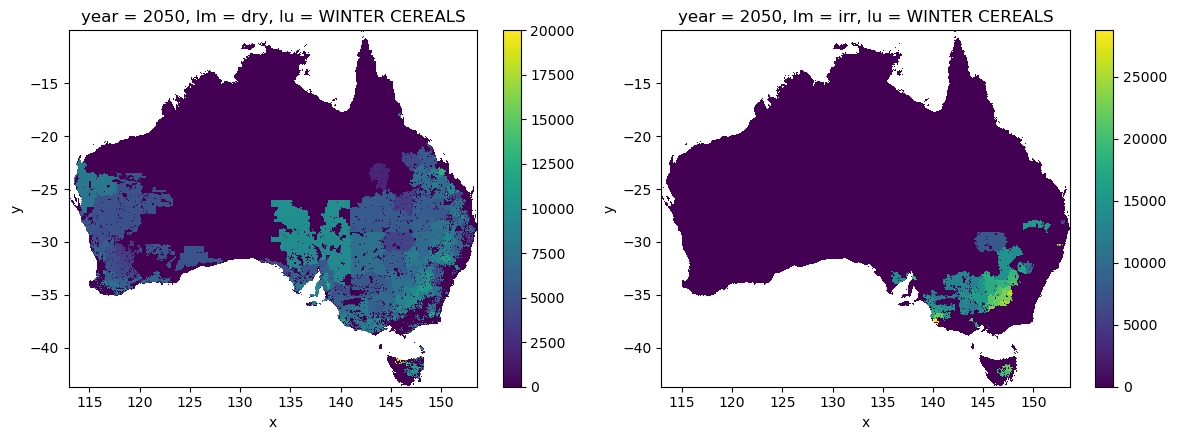

In [513]:
# HIDE CODE
q_dry_target = mrp_xr.sel(lm='dry', year=year_target, lu=lu_desc.upper()).drop_vars('spatial_ref')
q_irr_target = mrp_xr.sel(lm='irr', year=year_target, lu=lu_desc.upper()).drop_vars('spatial_ref')
plot_dry_irr(q_dry_target, q_irr_target)

## Costs and Revenues

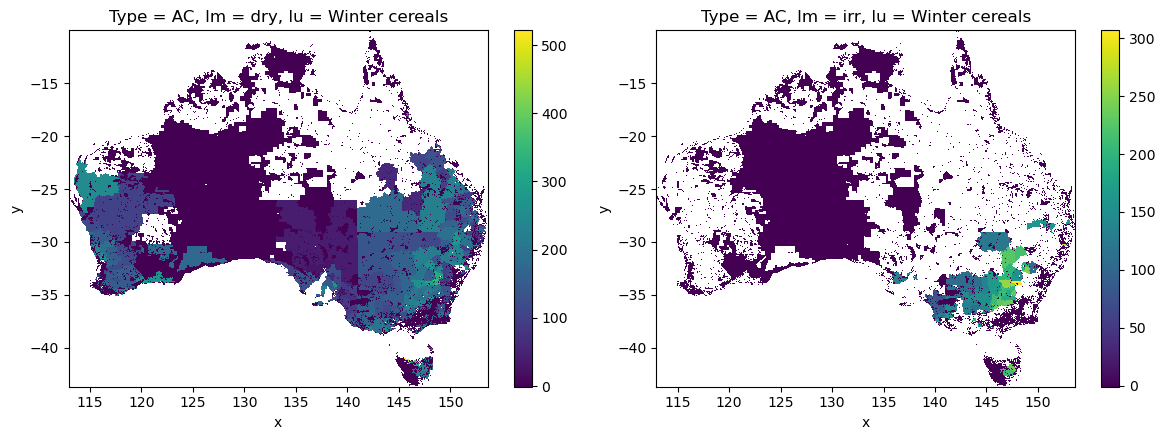

In [517]:
# HIDE CODE
c_dry = agec_crops_xr_lu.sel(Type='AC', lm='dry').drop_vars('spatial_ref')
c_irr = agec_crops_xr_lu.sel(Type='AC', lm='irr').drop_vars('spatial_ref')

plot_dry_irr(c_dry, c_irr)

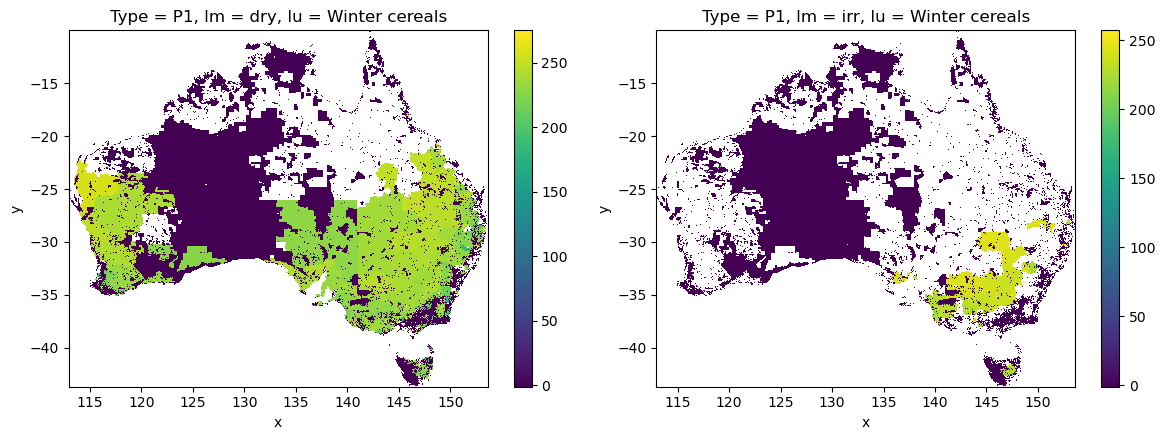

In [519]:
# HIDE CODE

r_dry = agec_crops_xr_lu.sel(Type='P1', lm='dry').drop_vars('spatial_ref')
r_irr = agec_crops_xr_lu.sel(Type='P1', lm='irr').drop_vars('spatial_ref')

plot_dry_irr(r_dry, r_irr)

## GHG emmisions

In [ ]:
# Convert the `AGEC_CROPS` data to 2D xarray
agghg_crops_xr = []
for col in data.AGGHG_CROPS.columns:
    series = data.AGGHG_CROPS[col]
    series_xr = arr_to_xr(data, series).expand_dims({
        'Type': [col[0]], 
        'lm': [col[1]], 
        'lu': [col[2]]
    })
    agghg_crops_xr.append(series_xr)

# Combine the xarray objects
agghg_crops_xr = xr.combine_by_coords(agghg_crops_xr)

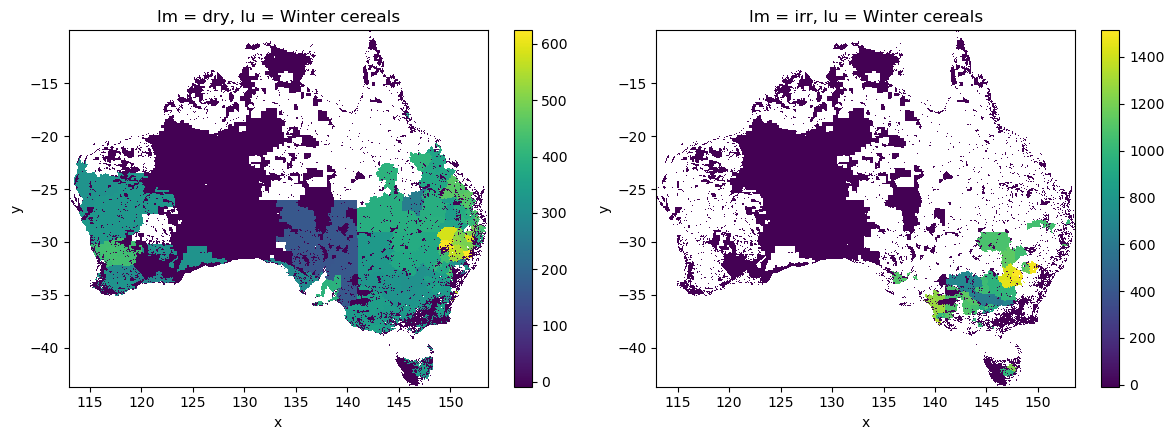

In [ ]:
# HIDE CODE
agghg_crops_xr_lu = agghg_crops_xr.sel(lu=lu_desc).sum(dim=['Type'], skipna=False)    # t/ha
ghg_dry = agghg_crops_xr_lu.sel(lm='dry').drop_vars('spatial_ref') 
ghg_irr = agghg_crops_xr_lu.sel(lm='irr').drop_vars('spatial_ref') 

plot_dry_irr(ghg_dry, ghg_irr)

## Find the optimized solution

In [199]:
# Get the available land for the given land-use
lu_arr_dry_aval = (lu_arr_dry == 0) * (q_dry > 0)
lu_arr_irr_aval = (lu_arr_irr == 0) * (q_irr > 0)

In [230]:
def rand_reduce_gap(in_dry, in_irr, q_dry, q_irr, gap, chunk_size=10):

    # Get the row/col for the non-zero values
    row_dry, col_dry = np.nonzero(in_dry)
    row_irr, col_irr = np.nonzero(in_irr)

    # Get the index for the non-zero values
    idx_dry = list(range(len(row_dry)))
    idx_irr = list(range(len(row_irr)))
    
    # Initialize the selected index
    sel_idx_dry = []
    sel_idx_irr = []
    
    # Loop until the gap is closed
    while gap>= 0:
        if len(idx_dry) <= chunk_size or len(idx_irr) <= chunk_size:
            print('Not enought land for the meeting the production gap.')
            break
        
        sel_dry = np.random.choice(idx_dry, chunk_size, replace=False)
        sel_irr = np.random.choice(idx_irr, chunk_size, replace=False)
        
        [idx_dry.remove(i) for i in sel_dry]
        [idx_irr.remove(i) for i in sel_irr]
        
        sel_idx_dry.extend(sel_dry)
        sel_idx_irr.extend(sel_irr)
        
        gap -= np.nansum(q_dry.values[row_dry.values[sel_dry], col_dry.values[sel_dry]])
        gap -= np.nansum(q_irr.values[row_irr.values[sel_irr], col_irr.values[sel_irr]])
        
    # Get the pred array
    pred_arr_dry = lu_arr_dry.copy()
    pred_arr_irr = lu_arr_irr.copy()
    
    pred_arr_dry.values[row_dry.values[sel_idx_dry], col_dry.values[sel_idx_dry]] = 2
    pred_arr_irr.values[row_irr.values[sel_idx_irr], col_irr.values[sel_idx_irr]] = 2
           
    return pred_arr_dry, pred_arr_irr

In [276]:
# Randomly select from available land to meet the production gap
from joblib import Parallel, delayed        

gap = (demand_vol - q_total) * 1e6 # tonnes
para_obj = Parallel(n_jobs=20)
tasks = (delayed(rand_reduce_gap)(lu_arr_dry_aval, lu_arr_irr_aval, q_dry, q_irr, gap, chunk_size=10) for _ in range(100))
results = para_obj(tasks)

In [499]:
q_dry

<xarray.DataArray (y: 673, x: 814)> Size: 2MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    lm       <U3 12B 'dry'
    lu       <U14 56B 'WINTER CEREALS'
  * x        (x) float64 7kB 113.0 113.0 113.0 113.1 ... 153.4 153.5 153.6 153.6
  * y        (y) float64 5kB -10.04 -10.09 -10.14 ... -43.54 -43.59 -43.64

In [327]:
# Combine all results to one xarray object
pred_arr_xr = []
for i,arr in enumerate(results):
    dry_arr = arr[0].expand_dims({'run': [i], 'lm':['dry']},)
    irr_arr = arr[1].expand_dims({'run': [i], 'lm':['irr']},)
    pred_arr_xr.append(dry_arr)
    pred_arr_xr.append(irr_arr)

# Combine the xarray objects
pred_arr_xr = xr.combine_by_coords(pred_arr_xr)   

# Get the cost of production 
cost_xr = pred_arr_xr * agec_crops_xr_lu * lu_area    # multiply by the area, so that we can convert $/ha or tonnes/ha to $/cell or tonnes/cell
cost_xr = cost_xr.sum(dim=[dim for dim in cost_xr.dims if dim not in ['Type','run']])

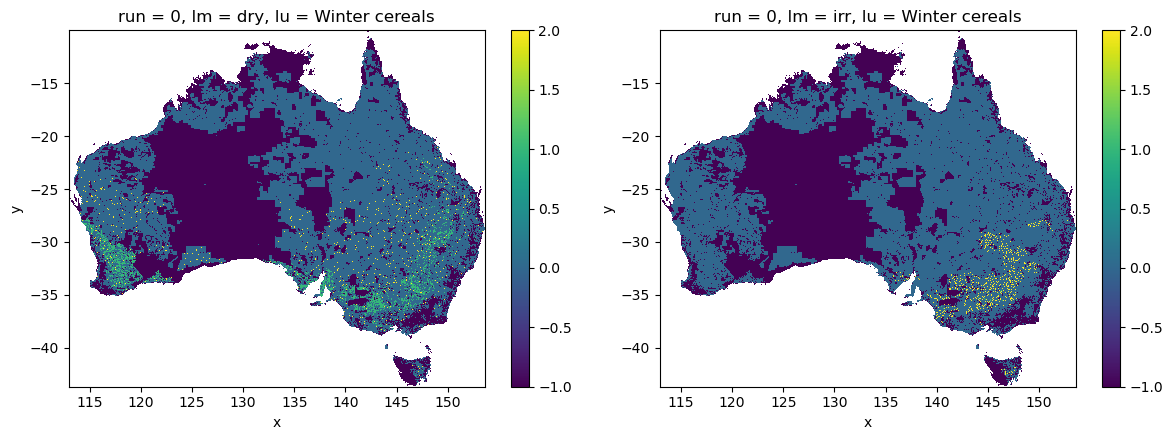

In [496]:
pred_dry = pred_arr_xr.sel(lm='dry', run=0).drop_vars('spatial_ref')
pred_irr = pred_arr_xr.sel(lm='irr', run=0).drop_vars('spatial_ref')

plot_dry_irr(pred_dry, pred_irr)

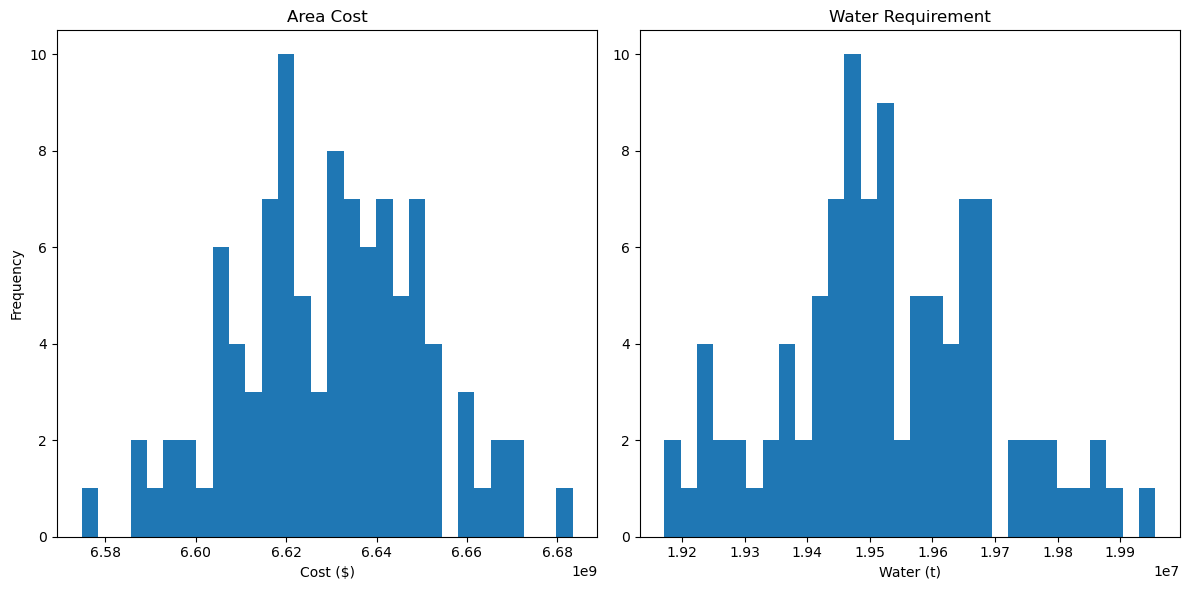

In [333]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


axs[0].hist(cost_xr.sel(Type='AC'), bins=30)
axs[0].set_title('Area Cost')
axs[0].set_xlabel('Cost ($)')
axs[0].set_ylabel('Frequency')

axs[1].hist(cost_xr.sel(Type='WR'), bins=30)
axs[1].set_title('Water Requirement')
axs[1].set_xlabel('Water (t)')

plt.tight_layout()

In [349]:
# Get the results with < $19.5M water requirement
cost_xr_w = cost_xr.sel(Type='WR') < 1.95 * 1e7
cost_xr_w_runs = cost_xr.coords['run'][cost_xr_w].values

cost_xr_AC_w_min = cost_xr.sel(Type='AC', run=cost_xr_w_runs).argmin(dim='run').values
cost_xr_AC_w_min = pred_arr_xr.sel(run=cost_xr_AC_w_min)

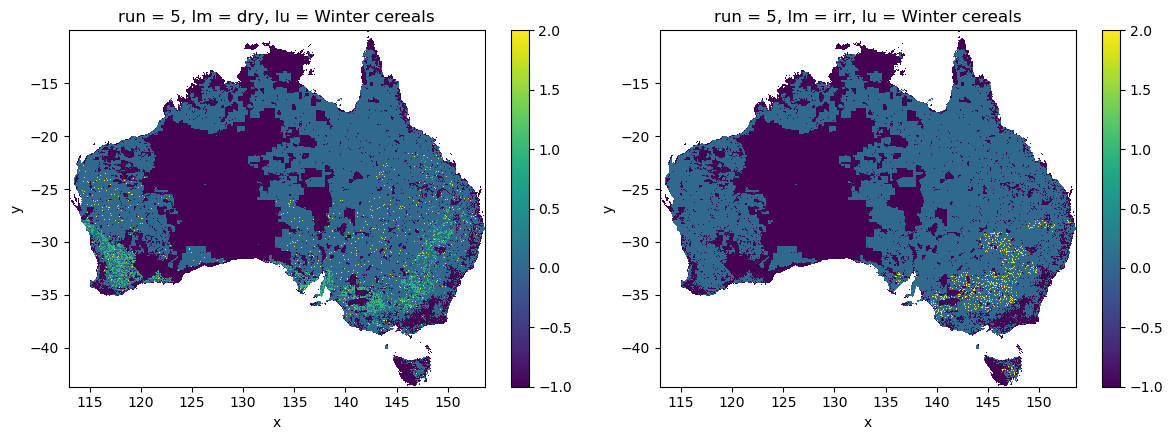

In [498]:
pred_dry_min_cost = cost_xr_AC_w_min.sel(lm='dry').drop_vars('spatial_ref')
pred_irr_min_cost = cost_xr_AC_w_min.sel(lm='irr').drop_vars('spatial_ref')

plot_dry_irr(pred_dry_min_cost, pred_irr_min_cost)